In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Load the Excel file
df_ref = pd.read_excel('BoxAB_PCD_Association.xlsx')

In [3]:
def get_object_perspective(cam_pose_x, cam_pose_y, box_x, box_y, box_z, box_rotation_w, box_rotation_z):
    """
    Determines the perspective of an object relative to the camera.

    Parameters:
    - box_center: np.array([x, y, z]) → center of the box in world coordinates
    - orientation_quat: Quaternion(w, 0, 0, z) → rotation around Z-axis only
    - cam_position: np.array([x, y, z]) → camera position in world coordinates
    - threshold: angle threshold in radians for classification

    Returns:
    - One of: 'toward', 'away', 'left', 'right'
    """
    threshold=np.pi / 4

    # Camera position in global coordinates
    cam_position = np.array([cam_pose_x, cam_pose_y, 0])  # shape: (3,)

    orientation_quat = Quaternion(
        box_rotation_w,
        0.0, 0.0,
        box_rotation_z
    )
    
    # Compute forward direction of the box (local +X axis rotated by orientation)
    forward_vector = orientation_quat.rotate(np.array([1, 0, 0]))  # shape: (3,)

    # Vector from box to camera
    box_center = [box_x, box_y, box_z]
    to_camera = cam_position - box_center
    to_camera = to_camera / np.linalg.norm(to_camera)

    # Compute angle between forward direction and camera vector
    dot = np.dot(forward_vector[:2], to_camera[:2])  # only XY plane
    angle = np.arccos(np.clip(dot, -1.0, 1.0))  # radians

    # Pad vectors to 3D by adding a zero Z-component
    forward_xy = np.array([forward_vector[0], forward_vector[1], 0])
    to_camera_xy = np.array([to_camera[0], to_camera[1], 0])
    
    # Compute cross product and extract Z-component
    cross_z = np.cross(forward_xy, to_camera_xy)[2]


    # Classify based on angle and cross product
    if angle < threshold:
        return 0 #'toward'
    elif angle > (np.pi - threshold):
        return 1 #'away'
    elif cross_z > 0:
        return 2 #'left'
    else:
        return 3 #'right'

In [4]:
# Load the Excel file

df = df_ref.copy()
cutoff_distance = 2
df_below_cutoff = df[df['a_radar_radar_distance'] <= cutoff_distance]

selected_columns = [
    'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 
    'b_camera_pose_x', 'b_camera_pose_y', 'b_camera_pose_z', 
    'a_box_translation_x', 'a_box_translation_y', 'a_box_translation_z', 
    'b_box_translation_x', 'b_box_translation_y', 'b_box_translation_z', 
    'a_box_size_l', 'a_box_size_w', 'a_box_size_h', 
    'b_box_size_l', 'b_box_size_w', 'b_box_size_h', 
    'a_box_rotation_w', 'a_box_rotation_x', 'a_box_rotation_y', 'a_box_rotation_z', 
    'b_box_rotation_w', 'b_box_rotation_x', 'b_box_rotation_y', 'b_box_rotation_z', 
    'a_box_category_name',
    'b_box_category_name', 
    'a_can_brake', 'a_can_brake_switch', 'a_can_rear_left_rpm', 'a_can_rear_right_rpm', 'a_can_vehicle_speed', 'a_can_yaw_rate',
    'b_can_brake', 'b_can_brake_switch', 'b_can_rear_left_rpm', 'b_can_rear_right_rpm', 'b_can_vehicle_speed', 'b_can_yaw_rate',
    'a_radar_radar_distance', 
    'b_radar_radar_distance', 
    'a_radar_dyn_prop',             
    'b_radar_dyn_prop']
    


df_below_cutoff = df_below_cutoff[selected_columns]

bins = [0, 3, 10, 20, 30, float('inf')]
labels = ['0', '3', '10', '20', '30']

# Create a new binned column
df_below_cutoff['a_can_vehicle_speed_bin'] = pd.cut(df_below_cutoff['a_can_vehicle_speed'], bins=bins, labels=labels, right=False)


# Encode box1_category_name
le_category = LabelEncoder()
df_below_cutoff['a_box_category_name_encoded'] = le_category.fit_transform(df_below_cutoff['a_box_category_name'])

def bin_yaw_rate(yaw):
    if yaw < -2.0:
        return -3; #'Sharp Left'
    elif -2.0 <= yaw < -1.0:
        return -2 #'Moderate Left'
    elif -1.0 <= yaw < -0.2:
        return -1 #'Gentle Left'
    elif -0.2 <= yaw <= 0.2:
        return 0 #'Straight'
    elif 0.2 < yaw <= 1.0:
        return 1 #'Gentle Right'
    elif 1.0 < yaw <= 2.0:
        return 2 #'Moderate Right'
    elif yaw > 2.0:
        return 3 #'Sharp Right'
    else:
        return 100 #'Unknown'

df_below_cutoff['a_can_yaw_rate_bin'] = df_below_cutoff['a_can_yaw_rate'].apply(bin_yaw_rate)
df_below_cutoff['b_can_yaw_rate_bin'] = df_below_cutoff['b_can_yaw_rate'].apply(bin_yaw_rate)

df_below_cutoff['a_box_perspective'] = df_below_cutoff.apply(
    lambda row: get_object_perspective(
        row['a_camera_pose_x'],
        row['a_camera_pose_y'],
        row['a_box_translation_x'],
        row['a_box_translation_y'],
        row['a_box_translation_z'],
        row['a_box_rotation_w'],
        row['a_box_rotation_z']
    ),
    axis=1
)

df_cleaned_data = df_below_cutoff.copy()

df_cleaned_data.columns

Index(['a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z',
       'b_camera_pose_x', 'b_camera_pose_y', 'b_camera_pose_z',
       'a_box_translation_x', 'a_box_translation_y', 'a_box_translation_z',
       'b_box_translation_x', 'b_box_translation_y', 'b_box_translation_z',
       'a_box_size_l', 'a_box_size_w', 'a_box_size_h', 'b_box_size_l',
       'b_box_size_w', 'b_box_size_h', 'a_box_rotation_w', 'a_box_rotation_x',
       'a_box_rotation_y', 'a_box_rotation_z', 'b_box_rotation_w',
       'b_box_rotation_x', 'b_box_rotation_y', 'b_box_rotation_z',
       'a_box_category_name', 'b_box_category_name', 'a_can_brake',
       'a_can_brake_switch', 'a_can_rear_left_rpm', 'a_can_rear_right_rpm',
       'a_can_vehicle_speed', 'a_can_yaw_rate', 'b_can_brake',
       'b_can_brake_switch', 'b_can_rear_left_rpm', 'b_can_rear_right_rpm',
       'b_can_vehicle_speed', 'b_can_yaw_rate', 'a_radar_radar_distance',
       'b_radar_radar_distance', 'a_radar_dyn_prop', 'b_radar_dyn_prop',
      

In [5]:
df_cleaned_data.head()

,a_camera_pose_x,a_camera_pose_y,a_camera_pose_z,b_camera_pose_x,b_camera_pose_y,b_camera_pose_z,a_box_translation_x,a_box_translation_y,a_box_translation_z,b_box_translation_x,...,b_can_yaw_rate,a_radar_radar_distance,b_radar_radar_distance,a_radar_dyn_prop,b_radar_dyn_prop,a_can_vehicle_speed_bin,a_box_category_name_encoded,a_can_yaw_rate_bin,b_can_yaw_rate_bin,a_box_perspective
0,411.419986,1181.197176,0,409.850669,1176.970211,0,373.256,1130.419,0.800,373.256,...,0.6,1.493656,1.657184,3,1,30,0,1,1,2
3,411.419986,1181.197176,0,409.850669,1176.970211,0,394.842,1158.711,0.487,394.842,...,0.6,0.727647,2.395325,1,1,30,3,1,1,2
4,411.419986,1181.197176,0,409.850669,1176.970211,0,394.842,1158.711,0.487,394.842,...,0.6,0.727647,0.801720,1,1,30,3,1,1,2
5,411.419986,1181.197176,0,409.850669,1176.970211,0,394.842,1158.711,0.487,394.842,...,0.6,0.930885,2.395325,1,1,30,3,1,1,2
6,411.419986,1181.197176,0,409.850669,1176.970211,0,394.842,1158.711,0.487,394.842,...,0.6,0.930885,0.801720,1,1,30,3,1,1,2


In [6]:
df_final_model_data = pd.DataFrame()

# Translation deltas
df_final_model_data['delta_translation_x'] = df_cleaned_data['b_box_translation_x'] - df_cleaned_data['a_box_translation_x']
df_final_model_data['delta_translation_y'] = df_cleaned_data['b_box_translation_y'] - df_cleaned_data['a_box_translation_y']
df_final_model_data['delta_translation_z'] = df_cleaned_data['b_box_translation_z'] - df_cleaned_data['a_box_translation_z']


def compute_delta_quaternion(row):
    q1 = Quaternion([row['a_box_rotation_w'], 0.0, 0.0, row['a_box_rotation_z']])
    q2 = Quaternion([row['b_box_rotation_w'], 0.0, 0.0, row['b_box_rotation_z']])
    delta_q = q2 * q1.inverse
    return pd.Series({'delta_rotation_w': delta_q.w, 'delta_rotation_x': delta_q.x, 'delta_rotation_y': delta_q.y,'delta_rotation_z': delta_q.z})

df_quat_delta = df_cleaned_data.apply(compute_delta_quaternion, axis=1)
df_final_model_data = pd.concat([df_final_model_data, df_quat_delta], axis=1)


df_final_model_data['a_box_size_l'] = df_cleaned_data['a_box_size_l']
df_final_model_data['a_box_size_w'] = df_cleaned_data['a_box_size_w']
df_final_model_data['a_box_size_h'] = df_cleaned_data['a_box_size_h']

# Vehicle speed delta
df_final_model_data['a_can_vehicle_speed_bin'] = df_cleaned_data['a_can_vehicle_speed_bin']
df_final_model_data['delta_vehicle_speed'] = df_cleaned_data['b_can_vehicle_speed'] - df_cleaned_data['a_can_vehicle_speed']

# Vehicle brake state
df_final_model_data['a_can_brake'] = df_cleaned_data['a_can_brake']
df_final_model_data['b_can_brake'] = df_cleaned_data['b_can_brake']

# Directly copied columns
df_final_model_data['a_box_category_name_encoded'] = df_cleaned_data['a_box_category_name_encoded']
df_final_model_data['a_radar_dyn_prop'] = df_cleaned_data['a_radar_dyn_prop']
df_final_model_data['b_radar_dyn_prop'] = df_cleaned_data['b_radar_dyn_prop']
df_final_model_data['a_can_yaw_rate_bin'] = df_cleaned_data['a_can_yaw_rate_bin']
df_final_model_data['b_can_yaw_rate_bin'] = df_cleaned_data['b_can_yaw_rate_bin']


df_final_model_data['a_box_category_name_encoded'] = df_final_model_data['a_box_category_name_encoded'].astype('category')
df_final_model_data['a_can_vehicle_speed_bin'] = df_final_model_data['a_can_vehicle_speed_bin'].astype('category')
df_final_model_data['a_radar_dyn_prop'] = df_final_model_data['a_radar_dyn_prop'].astype('category')
df_final_model_data['b_radar_dyn_prop'] = df_final_model_data['b_radar_dyn_prop'].astype('category')
df_final_model_data['a_can_yaw_rate_bin'] = df_final_model_data['a_can_yaw_rate_bin'].astype('category')
df_final_model_data['b_can_yaw_rate_bin'] = df_final_model_data['b_can_yaw_rate_bin'].astype('category')
df_final_model_data['a_can_brake'] = df_final_model_data['a_can_brake'].astype('category')
df_final_model_data['b_can_brake'] = df_final_model_data['b_can_brake'].astype('category')


df_final_model_data = df_final_model_data.drop_duplicates()
df_final_model_data.isna().sum()

delta_translation_x            0
delta_translation_y            0
delta_translation_z            0
delta_rotation_w               0
delta_rotation_x               0
delta_rotation_y               0
delta_rotation_z               0
a_box_size_l                   0
a_box_size_w                   0
a_box_size_h                   0
a_can_vehicle_speed_bin        0
delta_vehicle_speed            0
a_can_brake                    0
b_can_brake                    0
a_box_category_name_encoded    0
a_radar_dyn_prop               0
b_radar_dyn_prop               0
a_can_yaw_rate_bin             0
b_can_yaw_rate_bin             0
dtype: int64

In [7]:
df_final_model_data['a_radar_dyn_prop'].unique()

[3, 1, 0, 2, 5, 6]
Categories (6, int64): [0, 1, 2, 3, 5, 6]

In [8]:
df_final_model_data.dtypes

delta_translation_x             float64
delta_translation_y             float64
delta_translation_z             float64
delta_rotation_w                float64
delta_rotation_x                float64
delta_rotation_y                float64
delta_rotation_z                float64
a_box_size_l                    float64
a_box_size_w                    float64
a_box_size_h                    float64
a_can_vehicle_speed_bin        category
delta_vehicle_speed             float64
a_can_brake                    category
b_can_brake                    category
a_box_category_name_encoded    category
a_radar_dyn_prop               category
b_radar_dyn_prop               category
a_can_yaw_rate_bin             category
b_can_yaw_rate_bin             category
dtype: object

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Define columns to exclude
target_cols = ['a_radar_dyn_prop', 'b_radar_dyn_prop']


X = df_final_model_data.drop(columns=target_cols)
y1 = df_final_model_data['a_radar_dyn_prop']
y2 = df_final_model_data['b_radar_dyn_prop']

# Train-test split
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X, y1, y2, test_size=0.2, random_state=42
)

# Train models
model1 = RandomForestClassifier(n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    max_features='sqrt', class_weight='balanced',
    random_state=42)
model2 = RandomForestClassifier(n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    max_features='sqrt', class_weight='balanced',
    random_state=42)

model1.fit(X_train, y1_train)
model2.fit(X_train, y2_train)

# Predictions
y1_pred = model1.predict(X_test)
y2_pred = model2.predict(X_test)

# Evaluate
print("Radar1 Classification Report1:")
print(classification_report(y1_test, y1_pred))

print("Radar1 Classification Report2:")
print(classification_report(y1_test, y2_pred))

# Confusion Matrices
cm1 = confusion_matrix(y1_test, y1_pred)
print(cm1)

# Confusion Matrices
cm2 = confusion_matrix(y1_test, y2_pred)
print(cm2)


#0: moving, 1: stationary, 2: oncoming, 3: stationary candidate, 4: unknown, 5: crossing stationary, 6: crossing moving, 7: stopped

Radar1 Classification Report1:
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        47
           1       0.81      0.85      0.83       196
           2       0.90      0.69      0.78        26
           3       0.35      0.22      0.27        41
           5       0.40      0.33      0.36         6
           6       0.71      0.83      0.77        12

    accuracy                           0.75       328
   macro avg       0.65      0.64      0.64       328
weighted avg       0.74      0.75      0.74       328

Radar1 Classification Report2:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80        47
           1       0.79      0.83      0.81       196
           2       0.82      0.54      0.65        26
           3       0.27      0.20      0.23        41
           5       0.30      0.50      0.38         6
           6       0.58      0.58      0.58        12

    accuracy   

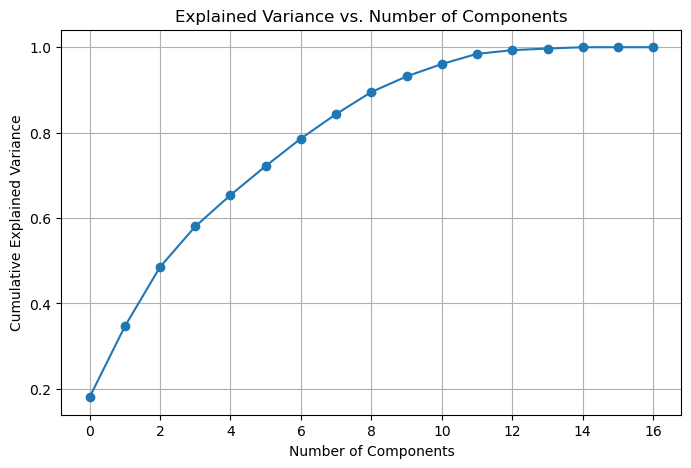

Use 11 components to retain 95% variance


In [10]:
# Define columns to exclude
target_cols = ['a_radar_dyn_prop', 'b_radar_dyn_prop']


X = df_final_model_data.drop(columns=target_cols)
y1 = df_final_model_data['a_radar_dyn_prop']
y2 = df_final_model_data['b_radar_dyn_prop']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

df_visualization_reset = df_final_model_data.reset_index(drop=True)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# Find number of components to reach 95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Use {n_components} components to retain 95% variance")


# Create a PCA DataFrame
#pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
#pca_df['a_radar_dyn_prop'] = df_visualization_reset['a_radar_dyn_prop']
#pca_df['b_radar_dyn_prop'] = df_visualization_reset['b_radar_dyn_prop']

In [11]:
# Define columns to exclude
target_cols = ['a_radar_dyn_prop', 'b_radar_dyn_prop']


X = df_final_model_data.drop(columns=target_cols)
y1 = df_final_model_data['a_radar_dyn_prop']
y2 = df_final_model_data['b_radar_dyn_prop']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)


# Create a PCA DataFrame
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12'])
pca_df['a_radar_dyn_prop'] = df_visualization_reset['a_radar_dyn_prop']
pca_df['b_radar_dyn_prop'] = df_visualization_reset['b_radar_dyn_prop']

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Define columns to exclude
target_cols = ['a_radar_dyn_prop', 'b_radar_dyn_prop']


X = pca_df.drop(columns=target_cols)
y1 = pca_df['a_radar_dyn_prop']
y2 = pca_df['b_radar_dyn_prop']

# Train-test split
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X, y1, y2, test_size=0.2, random_state=42
)

# Train models
model1 = RandomForestClassifier(n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    max_features='sqrt',
    random_state=42
)
model2 = RandomForestClassifier(n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    max_features='sqrt',
    random_state=42
)

model1.fit(X_train, y1_train)
model2.fit(X_train, y2_train)

# Predictions
y1_pred = model1.predict(X_test)
y2_pred = model2.predict(X_test)


# Evaluate
print("Radar1 Classification Report 1:")
print(classification_report(y1_test, y1_pred))

print("Radar2 Classification Report 2:")
print(classification_report(y1_test, y2_pred))

# Confusion Matrices
cm1 = confusion_matrix(y1_test, y1_pred)
cm2 = confusion_matrix(y1_test, y2_pred)

print(cm1)

print(cm2)


Radar1 Classification Report 1:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77        47
           1       0.78      0.94      0.85       196
           2       0.93      0.50      0.65        26
           3       0.50      0.07      0.13        41
           5       0.00      0.00      0.00         6
           6       0.61      0.92      0.73        12

    accuracy                           0.76       328
   macro avg       0.59      0.54      0.52       328
weighted avg       0.73      0.76      0.71       328

Radar2 Classification Report 2:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        47
           1       0.75      0.95      0.84       196
           2       0.91      0.38      0.54        26
           3       0.00      0.00      0.00        41
           5       0.29      0.33      0.31         6
           6       0.45      0.42      0.43        12

    accuracy 

In [13]:
#0: moving, 1: stationary, 2: oncoming, 3: stationary candidate, 4: unknown, 5: crossing stationary, 6: crossing moving, 7: stopped
